In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import random
import pickle
import itertools
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logomaker
import seaborn as sns
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from map4 import MAP4Calculator
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance

from mobius import SequenceGA, ScaffoldGA, GA
from mobius import Map4Fingerprint, SequenceDescriptors, DMTSimulation
from mobius import expected_improvement, greedy, probability_of_improvement, TanimotoSimilarityKernel
from mobius import HELMGeneticOperators
from mobius import Oracle
from mobius import affinity_binding_to_energy, energy_to_affinity_binding, compute_probability_matrix, plot_results
from mobius.helm import build_helm_string, parse_helm
from mobius.gaussian_process import GPModel
from mobius.acquisition_functions import AcqScoring
from mobius.generators import monomers_scanning, alanine_scanning, random_monomers_scanning, properties_scanning, scrumbled_scanning

In [3]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')
print(mhci[mhci['mhc_allele'].str.contains("HLA")]['mhc_allele'].unique().shape)

# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (mhci['length'] <= 11) &
            (mhci['length'] >= 9) &
            (~mhci['affinity_binding'].isin(dirty_values))]

print(mhci.shape)

(119,)
(8327, 7)


In [4]:
pssm_files = ['../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-8.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-9.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-10.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-11.txt']
mps = Oracle(pssm_files, mhci['sequence'], mhci['energy'], energy_cutoff=affinity_binding_to_energy(1, 'mM'))

----- Peptide global -----
N peptide: 8327
R2: 0.616
RMSD : 1.180 kcal/mol



In [5]:
map4 = Map4Fingerprint(input_type='helm', dimensions=4096, radius=1)

In [6]:
with open('../helm_ga/HELMCoreLibrary.json') as f:
    helm_core_library = json.load(f)

monomer_names = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
smiles = [x['smiles'] for x in helm_core_library if x['symbol'] in monomer_names and x['monomerType'] == 'Backbone']
    
probability_matrix = compute_probability_matrix(smiles)
helmgo = HELMGeneticOperators(monomer_names, probability_matrix)

In [30]:
energy_bounds = [affinity_binding_to_energy(15, 'uM'), affinity_binding_to_energy(20, 'uM')]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
init_sequence, init_score = mps.generate_random_peptides(1, 9, energy_bounds)
print(init_sequence, init_score, energy_to_affinity_binding(init_score, unit='uM'))

Energy bounds: -6.621 / -6.450 kcal/mol
['PEPTIDE1{H.Y.E.C.D.W.F.A.M}$$$$V2.0'] [-6.5374828] [17.26048522]


## Scumbled scanning

In [107]:
random_peptides = init_sequence.copy()
random_peptides_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in random_peptides]

for i, seq in enumerate(scrumbled_scanning(random_peptides_fasta[0])):
    random_peptides_fasta.append(seq)
    
    if len(random_peptides_fasta) >= 96:
        print('Reach max. number of peptides allowed.')
        break
        
random_peptides = [build_helm_string({'PEPTIDE1': f}) for f in random_peptides_fasta]
random_peptide_scores = mps.score(random_peptides_fasta)

print(len(random_peptides_fasta))
print(random_peptides_fasta)
print(random_peptide_scores)

Reach max. number of peptides allowed.
96
['HYECDWFAM', 'HMYEFADCW', 'FHDEMYAWC', 'EDWHAFYCM', 'MCFDEHAYW', 'MHEFYDAWC', 'YAEFDMHCW', 'AWYCFEDMH', 'AEHDCFWMY', 'ACYWEFHDM', 'ADYHFWCEM', 'AFEWCDHYM', 'EWMCDFAYH', 'EHFACYDWM', 'WCAFMDEYH', 'WYHFEMCAD', 'MWACDYHEF', 'AYEWCHMFD', 'AFDMWEHYC', 'FMAEHDWYC', 'YCAMWDEHF', 'ECDHAYWFM', 'HMEYWCADF', 'EMDWFHACY', 'YCADEWHFM', 'AFEDYCHWM', 'MCDAHWYEF', 'FDWEYAHMC', 'FHEDMWYCA', 'YMHWCDFAE', 'YAMCHFDEW', 'HFAEWMDCY', 'HADYCEWMF', 'YEDMHWCFA', 'YADWMFHCE', 'EWDYACMFH', 'YADEHCMFW', 'HWMAYDEFC', 'HCDAFYWME', 'WHMADFECY', 'CAYWFDMEH', 'HYCMAEDWF', 'WHMCYDFEA', 'FDCYEWMHA', 'HFDMYWCEA', 'FEMDCYAHW', 'MHYDAFCEW', 'DYEMAWHFC', 'CWEDYHFAM', 'MDWYHFECA', 'CHEAMYDFW', 'AMEDCHWYF', 'HYDFEAWMC', 'CYAFHDEMW', 'EDAWHCYFM', 'CAEDWHMYF', 'HWDAFCMYE', 'CWEHAYDMF', 'DWMHFCAEY', 'CMAWYDEHF', 'CWEHFAYMD', 'HYEWADFMC', 'CFMADYHWE', 'FAEYWDCHM', 'ADFEWCHYM', 'CMEFYAWDH', 'AWEDHMCFY', 'WDFECAMHY', 'FDMWCEAHY', 'CHEWYDFAM', 'FYWECDHMA', 'MWYEACFHD', 'WMAYCEDFH', 'CEMDHAW

Run: 1
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -10.433
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 013
Non binding pep        : 001


Generation: 1
N 001 - Score: -0.251353 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.C}$$$$V2.0 (000/050) - New seq: 469
N 002 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (000/050) - New seq: 430
N 003 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (001/050) - New seq: 437
N 004 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (000/050) - New seq: 418
N 005 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (001/050) - New seq: 423
N 006 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (002/050) - New seq: 407
N 007 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (003/050) - New 

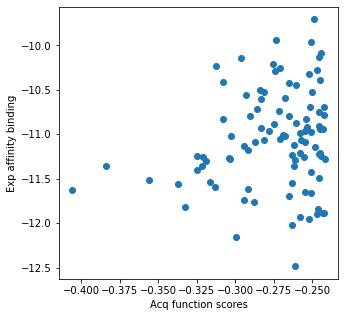

Run: 2
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -10.433
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 013
Non binding pep        : 001


Generation: 1
N 001 - Score: -0.251353 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.C}$$$$V2.0 (000/050) - New seq: 475
N 002 - Score: -0.251700 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.H.Y.S}$$$$V2.0 (000/050) - New seq: 416
N 003 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (000/050) - New seq: 424
N 004 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (000/050) - New seq: 425
N 005 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (001/050) - New seq: 430
N 006 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (002/050) - New seq: 403
N 007 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (003/050) - New 

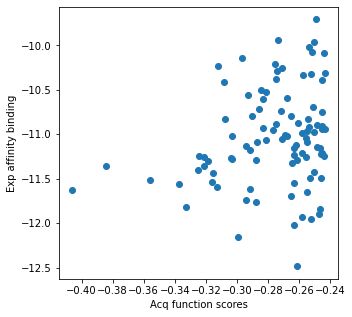

Run: 3
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -10.433
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 013
Non binding pep        : 001


Generation: 1
N 001 - Score: -0.251353 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.C}$$$$V2.0 (000/050) - New seq: 464
N 002 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (000/050) - New seq: 436
N 003 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (001/050) - New seq: 422
N 004 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (002/050) - New seq: 396
N 005 - Score: -0.406359 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (000/050) - New seq: 375
N 006 - Score: -0.406359 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (001/050) - New seq: 403
N 007 - Score: -0.406359 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (002/050) - New 

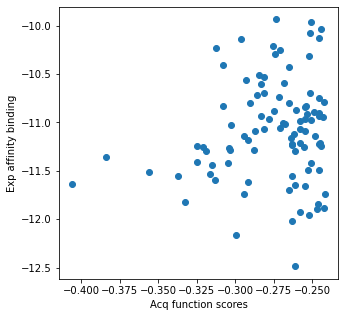

Run: 4
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -10.433
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 013
Non binding pep        : 001


Generation: 1
N 001 - Score: -0.251700 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.H.Y.S}$$$$V2.0 (000/050) - New seq: 466
N 002 - Score: -0.284369 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.C}$$$$V2.0 (000/050) - New seq: 435
N 003 - Score: -0.308358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.S}$$$$V2.0 (000/050) - New seq: 417
N 004 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (000/050) - New seq: 446
N 005 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (001/050) - New seq: 428
N 006 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (002/050) - New seq: 428
N 007 - Score: -0.406358 - Seq: 9 - PEPTIDE1{F.M.F.E.C.D.H.Y.A}$$$$V2.0 (003/050) - New 

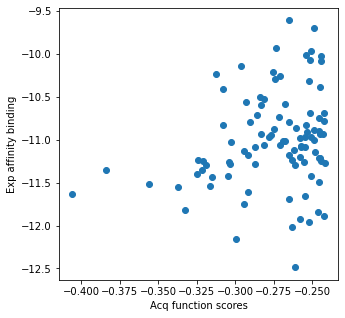

Run: 5
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -10.433
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 001
N pep under -9 kcal/mol: 002
N pep under -8 kcal/mol: 013
Non binding pep        : 001


Generation: 1
N 001 - Score: -0.251353 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.C}$$$$V2.0 (000/050) - New seq: 463
N 002 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (000/050) - New seq: 422
N 003 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (001/050) - New seq: 432
N 004 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (002/050) - New seq: 416
N 005 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (003/050) - New seq: 401
N 006 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (004/050) - New seq: 385
N 007 - Score: -0.332646 - Seq: 9 - PEPTIDE1{F.M.A.E.C.D.W.Y.A}$$$$V2.0 (005/050) - New 

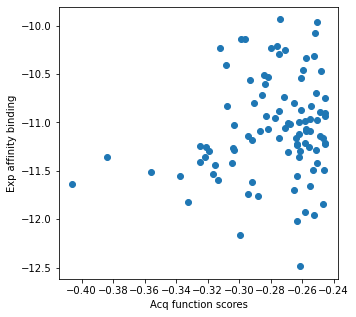

In [108]:
df = pd.read_csv('pca.csv')
f = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values

scaler = StandardScaler()
f = scaler.fit_transform(f)

df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = f

pcaseq = SequenceDescriptors(df)

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': TanimotoSimilarityKernel(), 'seq_transformer': map4, 'scaler': None,
              'n_gen': 1000, 'n_children': 500, 'temperature': 0.01, 'elitism': True, 'total_attempts': 50, 'cx_points': 2, 'pm': 0.1, 'minimum_mutations': 1, 'maximum_mutations': 5}

dmt = DMTSimulation(1, 5)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

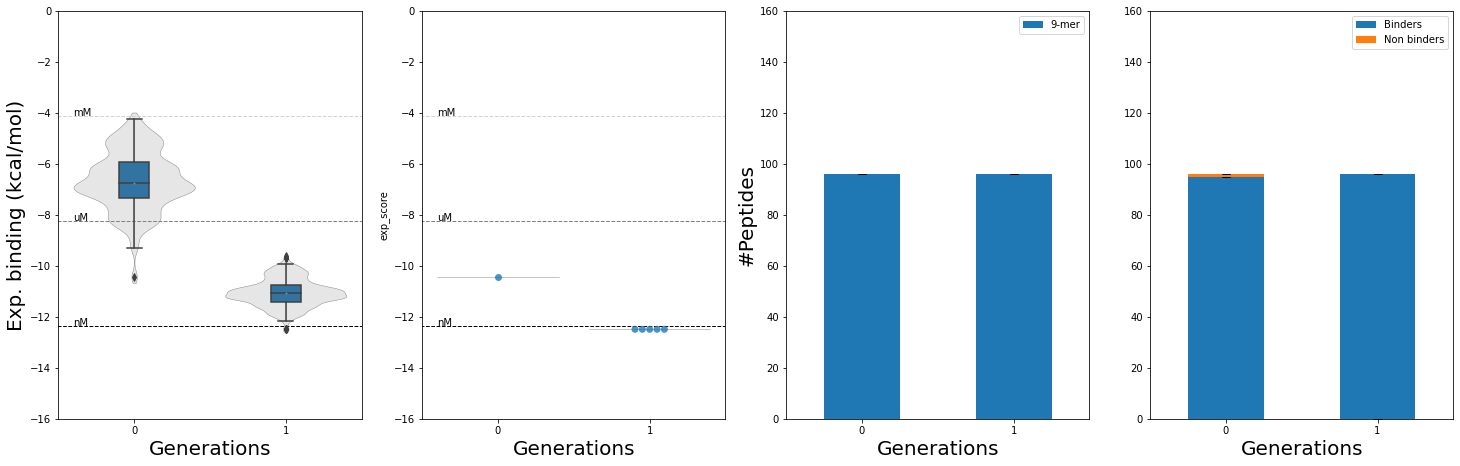

In [109]:
plot_results(df, 'test')

## Alanine scanning

In [76]:
random_peptides = init_sequence.copy()
random_peptides_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in random_peptides]

for seq in alanine_scanning(random_peptides_fasta[0], repeats=[2, 3]):
    random_peptides_fasta.append(seq)
    
    if len(random_peptides_fasta) >= 96:
        print('Reach max. number of peptides allowed.')
        break

random_peptides = [build_helm_string({'PEPTIDE1': f}) for f in random_peptides_fasta]
random_peptide_scores = mps.score(random_peptides_fasta)

print(len(random_peptides_fasta))
print(random_peptides_fasta)
print(random_peptide_scores)

Reach max. number of peptides allowed.
96
['HYECDWFAM', 'AYECDWFAM', 'HAECDWFAM', 'HYACDWFAM', 'HYEADWFAM', 'HYECAWFAM', 'HYECDAFAM', 'HYECDWAAM', 'HYECDWFAA', 'AAECDWFAM', 'AYACDWFAM', 'AYEADWFAM', 'AYECAWFAM', 'AYECDAFAM', 'AYECDWAAM', 'AYECDWFAM', 'AYECDWFAA', 'HAACDWFAM', 'HAEADWFAM', 'HAECAWFAM', 'HAECDAFAM', 'HAECDWAAM', 'HAECDWFAM', 'HAECDWFAA', 'HYAADWFAM', 'HYACAWFAM', 'HYACDAFAM', 'HYACDWAAM', 'HYACDWFAM', 'HYACDWFAA', 'HYEAAWFAM', 'HYEADAFAM', 'HYEADWAAM', 'HYEADWFAM', 'HYEADWFAA', 'HYECAAFAM', 'HYECAWAAM', 'HYECAWFAM', 'HYECAWFAA', 'HYECDAAAM', 'HYECDAFAM', 'HYECDAFAA', 'HYECDWAAM', 'HYECDWAAA', 'HYECDWFAA', 'AAACDWFAM', 'AAEADWFAM', 'AAECAWFAM', 'AAECDAFAM', 'AAECDWAAM', 'AAECDWFAM', 'AAECDWFAA', 'AYAADWFAM', 'AYACAWFAM', 'AYACDAFAM', 'AYACDWAAM', 'AYACDWFAM', 'AYACDWFAA', 'AYEAAWFAM', 'AYEADAFAM', 'AYEADWAAM', 'AYEADWFAM', 'AYEADWFAA', 'AYECAAFAM', 'AYECAWAAM', 'AYECAWFAM', 'AYECAWFAA', 'AYECDAAAM', 'AYECDAFAM', 'AYECDAFAA', 'AYECDWAAM', 'AYECDWAAA', 'AYECDWFAA', 'HAAADWF

Run: 1
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.078
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.339999 - Seq: 9 - PEPTIDE1{S.A.A.C.S.W.F.A.A}$$$$V2.0 (000/050) - New seq: 458
N 002 - Score: -0.370842 - Seq: 9 - PEPTIDE1{T.A.A.C.S.F.F.A.A}$$$$V2.0 (000/050) - New seq: 451
N 003 - Score: -0.387971 - Seq: 9 - PEPTIDE1{T.A.A.S.S.F.F.A.A}$$$$V2.0 (000/050) - New seq: 449
N 004 - Score: -0.399132 - Seq: 9 - PEPTIDE1{S.S.A.C.F.F.F.S.S}$$$$V2.0 (000/050) - New seq: 466
N 005 - Score: -0.416799 - Seq: 9 - PEPTIDE1{S.S.A.S.S.F.F.S.S}$$$$V2.0 (000/050) - New seq: 459
N 006 - Score: -0.416799 - Seq: 9 - PEPTIDE1{S.S.A.S.S.F.F.S.S}$$$$V2.0 (001/050) - New seq: 453
N 007 - Score: -0.426475 - Seq: 9 - PEPTIDE1{S.S.S.S.S.F.F.S.V}$$$$V2.0 (000/050) - New s

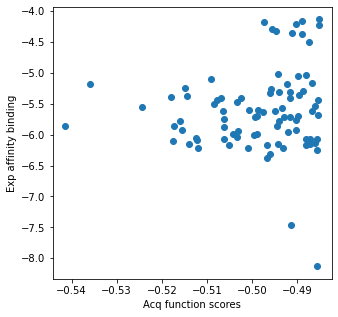

Run: 2
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.078
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.313485 - Seq: 9 - PEPTIDE1{A.A.A.C.F.W.F.A.A}$$$$V2.0 (000/050) - New seq: 453
N 002 - Score: -0.330289 - Seq: 9 - PEPTIDE1{A.A.A.C.F.G.F.A.A}$$$$V2.0 (000/050) - New seq: 437
N 003 - Score: -0.361821 - Seq: 9 - PEPTIDE1{C.G.A.C.F.G.F.S.A}$$$$V2.0 (000/050) - New seq: 452
N 004 - Score: -0.394692 - Seq: 9 - PEPTIDE1{V.G.A.F.F.G.F.S.G}$$$$V2.0 (000/050) - New seq: 464
N 005 - Score: -0.418088 - Seq: 9 - PEPTIDE1{C.G.C.C.F.G.F.S.G}$$$$V2.0 (000/050) - New seq: 475
N 006 - Score: -0.443967 - Seq: 9 - PEPTIDE1{G.G.C.C.F.G.F.S.G}$$$$V2.0 (000/050) - New seq: 461
N 007 - Score: -0.462604 - Seq: 9 - PEPTIDE1{G.G.C.C.G.G.F.S.G}$$$$V2.0 (000/050) - New s

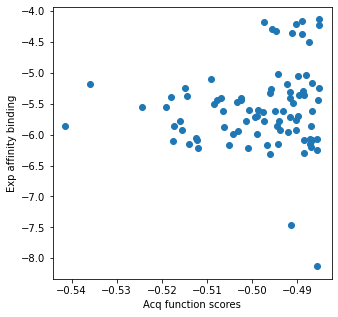

Run: 3
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.078
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.318273 - Seq: 9 - PEPTIDE1{S.A.A.C.D.W.F.A.A}$$$$V2.0 (000/050) - New seq: 453
N 002 - Score: -0.357505 - Seq: 9 - PEPTIDE1{T.A.A.A.S.W.F.A.C}$$$$V2.0 (000/050) - New seq: 443
N 003 - Score: -0.366032 - Seq: 9 - PEPTIDE1{T.A.A.A.S.W.F.S.S}$$$$V2.0 (000/050) - New seq: 465
N 004 - Score: -0.398105 - Seq: 9 - PEPTIDE1{S.A.A.A.S.F.F.S.C}$$$$V2.0 (000/050) - New seq: 456
N 005 - Score: -0.403980 - Seq: 9 - PEPTIDE1{S.A.A.S.S.F.F.S.C}$$$$V2.0 (000/050) - New seq: 466
N 006 - Score: -0.403980 - Seq: 9 - PEPTIDE1{S.A.A.S.S.F.F.S.C}$$$$V2.0 (001/050) - New seq: 452
N 007 - Score: -0.406792 - Seq: 9 - PEPTIDE1{S.S.A.A.S.F.F.S.S}$$$$V2.0 (000/050) - New s

N 083 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (020/050) - New seq: 363
N 084 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (021/050) - New seq: 322
N 085 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (022/050) - New seq: 335
N 086 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (023/050) - New seq: 332
N 087 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (024/050) - New seq: 328
N 088 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (025/050) - New seq: 331
N 089 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (026/050) - New seq: 324
N 090 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (027/050) - New seq: 329
N 091 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (028/050) - New seq: 326
N 092 - Score: -0.562065 - Seq: 9 - PEPTIDE1{G.G.G.G.G.G.G.G.G}$$$$V2.0 (029/050) - New seq: 324
N 093 - Score: -0.562065 - Seq

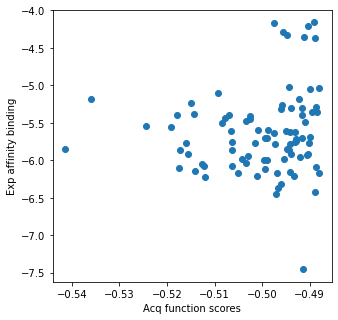

Run: 4
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.078
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.317936 - Seq: 9 - PEPTIDE1{A.A.A.C.D.W.F.A.S}$$$$V2.0 (000/050) - New seq: 444
N 002 - Score: -0.348836 - Seq: 9 - PEPTIDE1{A.A.A.C.A.F.F.A.S}$$$$V2.0 (000/050) - New seq: 458
N 003 - Score: -0.371836 - Seq: 9 - PEPTIDE1{A.A.A.G.A.F.F.A.S}$$$$V2.0 (000/050) - New seq: 457
N 004 - Score: -0.387631 - Seq: 9 - PEPTIDE1{V.G.A.G.A.F.F.A.A}$$$$V2.0 (000/050) - New seq: 453
N 005 - Score: -0.420820 - Seq: 9 - PEPTIDE1{G.A.A.G.A.F.F.S.G}$$$$V2.0 (000/050) - New seq: 475
N 006 - Score: -0.461200 - Seq: 9 - PEPTIDE1{G.G.S.G.F.F.F.S.G}$$$$V2.0 (000/050) - New seq: 460
N 007 - Score: -0.476151 - Seq: 9 - PEPTIDE1{G.A.A.G.G.F.F.G.G}$$$$V2.0 (000/050) - New s

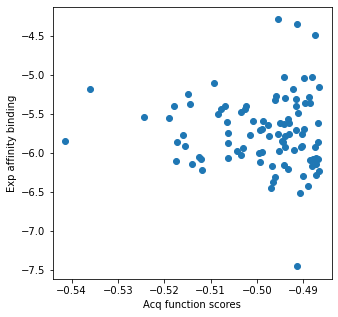

Run: 5
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.078
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.321677 - Seq: 9 - PEPTIDE1{A.A.A.C.D.W.F.S.C}$$$$V2.0 (000/050) - New seq: 444
N 002 - Score: -0.347214 - Seq: 9 - PEPTIDE1{A.A.A.C.D.W.F.S.G}$$$$V2.0 (000/050) - New seq: 443
N 003 - Score: -0.364501 - Seq: 9 - PEPTIDE1{S.A.A.C.S.W.F.S.C}$$$$V2.0 (000/050) - New seq: 451
N 004 - Score: -0.390014 - Seq: 9 - PEPTIDE1{S.A.A.G.S.W.F.S.G}$$$$V2.0 (000/050) - New seq: 468
N 005 - Score: -0.422872 - Seq: 9 - PEPTIDE1{G.S.A.C.C.F.F.S.G}$$$$V2.0 (000/050) - New seq: 464
N 006 - Score: -0.454021 - Seq: 9 - PEPTIDE1{G.S.S.G.S.F.F.S.G}$$$$V2.0 (000/050) - New seq: 466
N 007 - Score: -0.455641 - Seq: 9 - PEPTIDE1{G.G.S.G.S.S.F.S.G}$$$$V2.0 (000/050) - New s

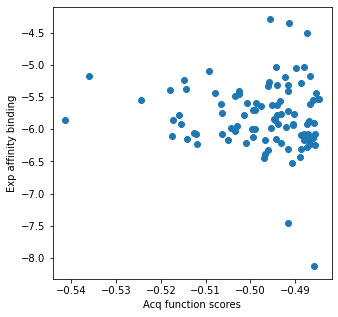

In [32]:
df = pd.read_csv('pca.csv')
f = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values

scaler = StandardScaler()
f = scaler.fit_transform(f)

df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = f

pcaseq = SequenceDescriptors(df)

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': TanimotoSimilarityKernel(), 'seq_transformer': map4, 'scaler': None,
              'n_gen': 1000, 'n_children': 500, 'temperature': 0.01, 'elitism': True, 'total_attempts': 50, 'cx_points': 2, 'pm': 0.1, 'minimum_mutations': 1, 'maximum_mutations': 5}

dmt = DMTSimulation(1, 5)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

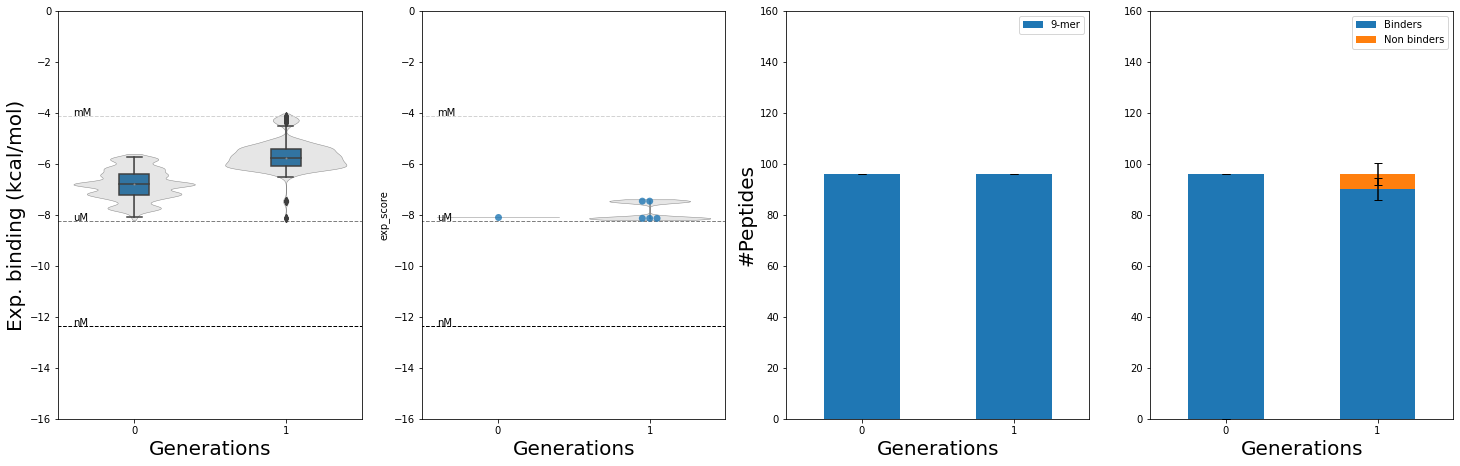

In [33]:
plot_results(df, 'test')

## Property scanning (manually picked AAs)

In [77]:
random_peptides = init_sequence.copy()
random_peptides_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in random_peptides]

for seq in monomers_scanning(random_peptides_fasta[0], 'HREWVSNCPY'):
    random_peptides_fasta.append(seq)
    
    if len(random_peptides_fasta) >= 96:
        print('Reach max. number of peptides allowed.')
        break

random_peptides = [build_helm_string({'PEPTIDE1': f}) for f in random_peptides_fasta]
random_peptide_scores = mps.score(random_peptides_fasta)

print(len(random_peptides_fasta))
print(random_peptides_fasta)
print(random_peptide_scores)

86
['HYECDWFAM', 'RYECDWFAM', 'EYECDWFAM', 'WYECDWFAM', 'VYECDWFAM', 'SYECDWFAM', 'NYECDWFAM', 'CYECDWFAM', 'PYECDWFAM', 'YYECDWFAM', 'HHECDWFAM', 'HRECDWFAM', 'HEECDWFAM', 'HWECDWFAM', 'HVECDWFAM', 'HSECDWFAM', 'HNECDWFAM', 'HCECDWFAM', 'HPECDWFAM', 'HYHCDWFAM', 'HYRCDWFAM', 'HYWCDWFAM', 'HYVCDWFAM', 'HYSCDWFAM', 'HYNCDWFAM', 'HYCCDWFAM', 'HYPCDWFAM', 'HYYCDWFAM', 'HYEHDWFAM', 'HYERDWFAM', 'HYEEDWFAM', 'HYEWDWFAM', 'HYEVDWFAM', 'HYESDWFAM', 'HYENDWFAM', 'HYEPDWFAM', 'HYEYDWFAM', 'HYECHWFAM', 'HYECRWFAM', 'HYECEWFAM', 'HYECWWFAM', 'HYECVWFAM', 'HYECSWFAM', 'HYECNWFAM', 'HYECCWFAM', 'HYECPWFAM', 'HYECYWFAM', 'HYECDHFAM', 'HYECDRFAM', 'HYECDEFAM', 'HYECDVFAM', 'HYECDSFAM', 'HYECDNFAM', 'HYECDCFAM', 'HYECDPFAM', 'HYECDYFAM', 'HYECDWHAM', 'HYECDWRAM', 'HYECDWEAM', 'HYECDWWAM', 'HYECDWVAM', 'HYECDWSAM', 'HYECDWNAM', 'HYECDWCAM', 'HYECDWPAM', 'HYECDWYAM', 'HYECDWFHM', 'HYECDWFRM', 'HYECDWFEM', 'HYECDWFWM', 'HYECDWFVM', 'HYECDWFSM', 'HYECDWFNM', 'HYECDWFCM', 'HYECDWFPM', 'HYECDWFYM', 'HYECDWF

Run: 1
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.089
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.384554 - Seq: 9 - PEPTIDE1{H.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 448
N 002 - Score: -0.384554 - Seq: 9 - PEPTIDE1{H.V.W.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 433
N 003 - Score: -0.477463 - Seq: 9 - PEPTIDE1{Y.V.W.C.A.W.F.A.M}$$$$V2.0 (000/050) - New seq: 417
N 004 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 441
N 005 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 419
N 006 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 402
N 007 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (003/050) - New s

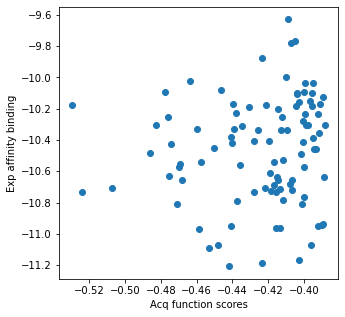

Run: 2
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.089
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.314330 - Seq: 9 - PEPTIDE1{H.Y.W.C.D.W.F.A.V}$$$$V2.0 (000/050) - New seq: 442
N 002 - Score: -0.475992 - Seq: 9 - PEPTIDE1{F.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 433
N 003 - Score: -0.475992 - Seq: 9 - PEPTIDE1{F.V.W.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 441
N 004 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 429
N 005 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 411
N 006 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 400
N 007 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (003/050) - New s

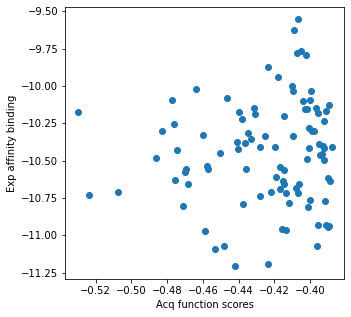

Run: 3
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.089
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.384554 - Seq: 9 - PEPTIDE1{H.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 448
N 002 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 448
N 003 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 430
N 004 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 412
N 005 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 377
N 006 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (004/050) - New seq: 398
N 007 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (005/050) - New s

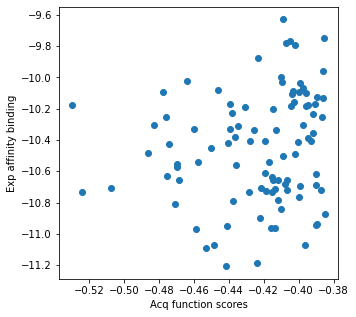

Run: 4
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.089
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.357407 - Seq: 9 - PEPTIDE1{H.Y.W.C.D.M.F.A.V}$$$$V2.0 (000/050) - New seq: 444
N 002 - Score: -0.358247 - Seq: 9 - PEPTIDE1{H.Y.W.C.W.M.F.A.V}$$$$V2.0 (000/050) - New seq: 422
N 003 - Score: -0.358247 - Seq: 9 - PEPTIDE1{H.Y.W.C.W.M.F.A.V}$$$$V2.0 (001/050) - New seq: 417
N 004 - Score: -0.358247 - Seq: 9 - PEPTIDE1{H.Y.W.C.W.M.F.A.V}$$$$V2.0 (002/050) - New seq: 404
N 005 - Score: -0.368530 - Seq: 9 - PEPTIDE1{H.V.W.C.D.W.F.A.V}$$$$V2.0 (000/050) - New seq: 401
N 006 - Score: -0.380450 - Seq: 9 - PEPTIDE1{Y.Y.W.C.W.M.F.A.V}$$$$V2.0 (000/050) - New seq: 412
N 007 - Score: -0.396077 - Seq: 9 - PEPTIDE1{Y.Y.W.C.M.W.F.A.V}$$$$V2.0 (000/050) - New s

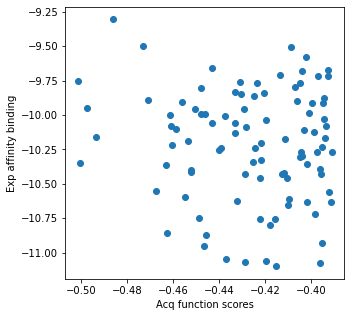

Run: 5
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.089
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.384554 - Seq: 9 - PEPTIDE1{H.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 443
N 002 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 429
N 003 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 410
N 004 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 397
N 005 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 378
N 006 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (004/050) - New seq: 369
N 007 - Score: -0.529931 - Seq: 9 - PEPTIDE1{Y.V.W.C.D.W.F.A.M}$$$$V2.0 (005/050) - New s

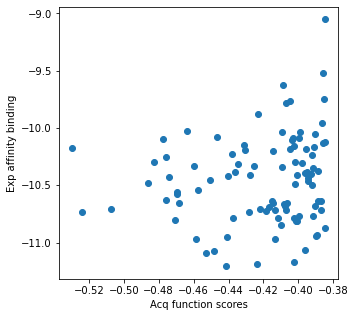

In [35]:
df = pd.read_csv('pca.csv')
f = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values

scaler = StandardScaler()
f = scaler.fit_transform(f)

df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = f

pcaseq = SequenceDescriptors(df)

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': TanimotoSimilarityKernel(), 'seq_transformer': map4, 'scaler': None,
              'n_gen': 1000, 'n_children': 500, 'temperature': 0.01, 'elitism': True, 'total_attempts': 50, 'cx_points': 2, 'pm': 0.1, 'minimum_mutations': 1, 'maximum_mutations': 5}

dmt = DMTSimulation(1, 5)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

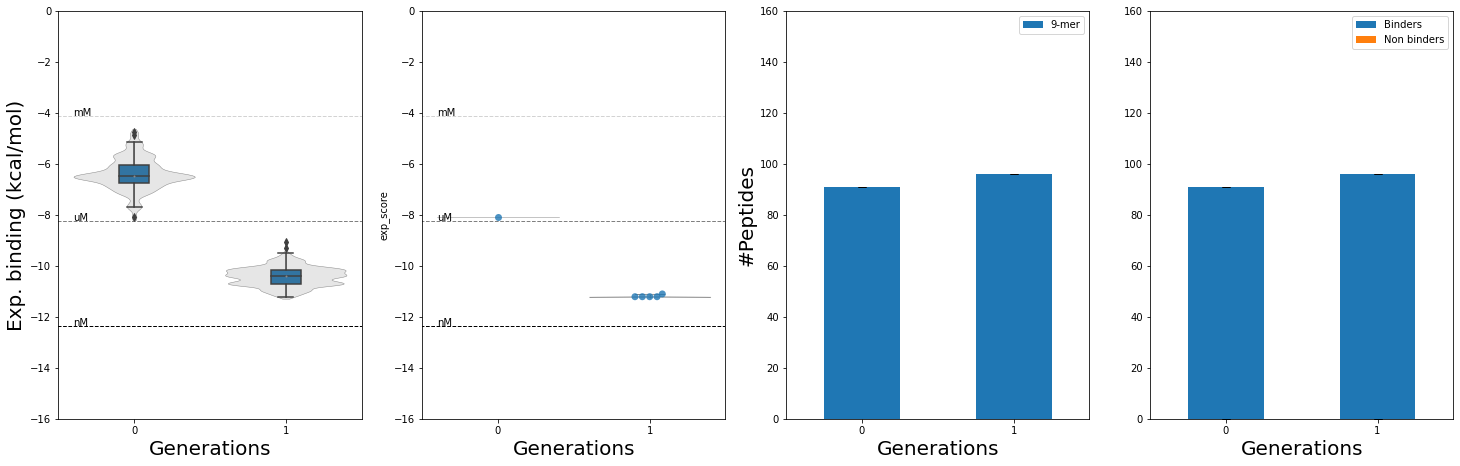

In [36]:
plot_results(df, 'test')

## Property scanning (Algorithmically picked AAs)

In [ ]:
def min_max(embedding, landmarks, n_landmarks):
    
    m = distance.cdist(embedding[landmarks[0], None], embedding).flatten()
    
    for i in range(1, len(landmarks)):
        e = distance.cdist(embedding[landmarks[i], None], embedding).flatten()
        m = np.minimum(m, e)
    
    for i in range(len(landmarks), n_landmarks):
        landmarks.append(np.argmax(m))
        e = distance.cdist(embedding[landmarks[i], None], embedding).flatten()
        m = np.minimum(m, e)
    
    return np.array(landmarks)

In [203]:
df = pd.read_csv('pca.csv')
f = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values

scaler = StandardScaler()
#f = scaler.fit_transform(f)

#df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = f

n = MDS(max_iter=1000, n_init=15)
embedding_mds_b = n.fit_transform(X=f)
print(n.stress_)

7.49427616057717


In [204]:
landmarks = min_max(euclidean_distances(f), [4], np.floor(95 / 9).astype(int))
print(landmarks)
print(df['AA3'][landmarks].values)

[ 4 11 14 13 15  0 19  3  7 18]
['CYS' 'LYS' 'PRO' 'PHE' 'SER' 'ALA' 'VAL' 'ASP' 'GLY' 'TYR']


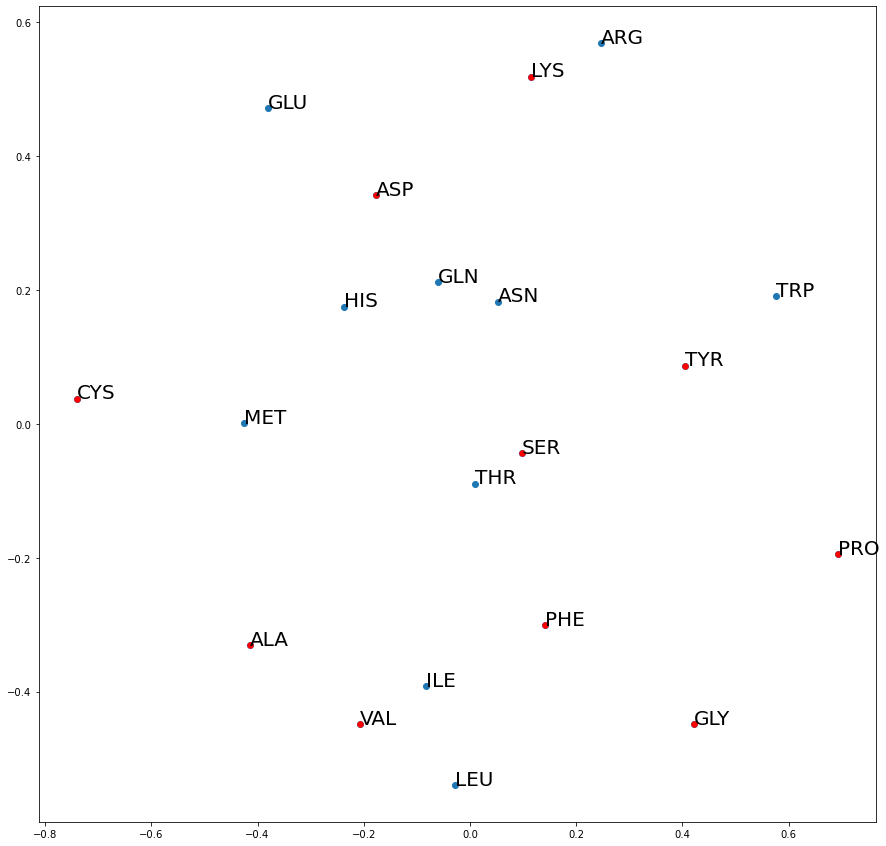

In [205]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(embedding_mds_b[:,0], embedding_mds_b[:,1])

for l in landmarks:
    ax.scatter(embedding_mds_b[l,0], embedding_mds_b[l,1], 30, 'red')

for AA, coor in zip(df['AA3'], embedding_mds_b):
    ax.text(coor[0], coor[1], AA, fontsize=20)
    
#plt.savefig('multidimensional_scaling_embedding_backbone.png', dpi=300, bbox_inches='tight')
plt.show()

In [78]:
random_peptides = init_sequence.copy()
random_peptides_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in random_peptides]

for seq in monomers_scanning(random_peptides_fasta[0], 'CKPFSAVDGY'):
    random_peptides_fasta.append(seq)
    
    if len(random_peptides_fasta) >= 96:
        print('Reach max. number of peptides allowed.')
        break

random_peptides = [build_helm_string({'PEPTIDE1': f}) for f in random_peptides_fasta]
random_peptide_scores = mps.score(random_peptides_fasta)

print(len(random_peptides_fasta))
print(random_peptides_fasta)
print(random_peptide_scores)

86
['HYECDWFAM', 'CYECDWFAM', 'KYECDWFAM', 'PYECDWFAM', 'FYECDWFAM', 'SYECDWFAM', 'AYECDWFAM', 'VYECDWFAM', 'DYECDWFAM', 'GYECDWFAM', 'YYECDWFAM', 'HCECDWFAM', 'HKECDWFAM', 'HPECDWFAM', 'HFECDWFAM', 'HSECDWFAM', 'HAECDWFAM', 'HVECDWFAM', 'HDECDWFAM', 'HGECDWFAM', 'HYCCDWFAM', 'HYKCDWFAM', 'HYPCDWFAM', 'HYFCDWFAM', 'HYSCDWFAM', 'HYACDWFAM', 'HYVCDWFAM', 'HYDCDWFAM', 'HYGCDWFAM', 'HYYCDWFAM', 'HYEKDWFAM', 'HYEPDWFAM', 'HYEFDWFAM', 'HYESDWFAM', 'HYEADWFAM', 'HYEVDWFAM', 'HYEDDWFAM', 'HYEGDWFAM', 'HYEYDWFAM', 'HYECCWFAM', 'HYECKWFAM', 'HYECPWFAM', 'HYECFWFAM', 'HYECSWFAM', 'HYECAWFAM', 'HYECVWFAM', 'HYECGWFAM', 'HYECYWFAM', 'HYECDCFAM', 'HYECDKFAM', 'HYECDPFAM', 'HYECDFFAM', 'HYECDSFAM', 'HYECDAFAM', 'HYECDVFAM', 'HYECDDFAM', 'HYECDGFAM', 'HYECDYFAM', 'HYECDWCAM', 'HYECDWKAM', 'HYECDWPAM', 'HYECDWSAM', 'HYECDWAAM', 'HYECDWVAM', 'HYECDWDAM', 'HYECDWGAM', 'HYECDWYAM', 'HYECDWFCM', 'HYECDWFKM', 'HYECDWFPM', 'HYECDWFFM', 'HYECDWFSM', 'HYECDWFVM', 'HYECDWFDM', 'HYECDWFGM', 'HYECDWFYM', 'HYECDWF

Run: 1
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -7.787
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.590096 - Seq: 9 - PEPTIDE1{F.Y.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 452
N 002 - Score: -0.645698 - Seq: 9 - PEPTIDE1{F.I.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 433
N 003 - Score: -0.645698 - Seq: 9 - PEPTIDE1{F.I.F.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 412
N 004 - Score: -0.747384 - Seq: 9 - PEPTIDE1{F.V.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 391
N 005 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 435
N 006 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 412
N 007 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (002/050) - New s

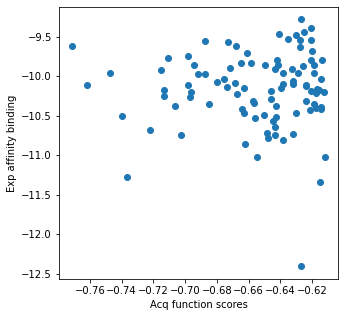

Run: 2
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -7.787
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.603354 - Seq: 9 - PEPTIDE1{F.Y.F.C.F.W.F.A.M}$$$$V2.0 (000/050) - New seq: 432
N 002 - Score: -0.747381 - Seq: 9 - PEPTIDE1{F.V.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 414
N 003 - Score: -0.747381 - Seq: 9 - PEPTIDE1{F.V.F.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 428
N 004 - Score: -0.747381 - Seq: 9 - PEPTIDE1{F.V.F.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 410
N 005 - Score: -0.761607 - Seq: 9 - PEPTIDE1{F.V.D.C.W.W.F.A.M}$$$$V2.0 (000/050) - New seq: 402
N 006 - Score: -0.761607 - Seq: 9 - PEPTIDE1{F.V.D.C.W.W.F.A.M}$$$$V2.0 (001/050) - New seq: 405
N 007 - Score: -0.761607 - Seq: 9 - PEPTIDE1{F.V.D.C.W.W.F.A.M}$$$$V2.0 (002/050) - New s

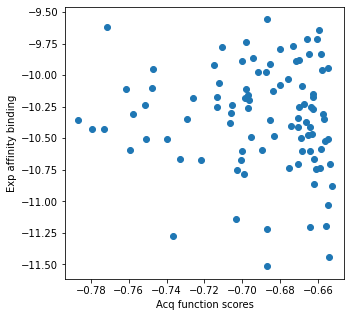

Run: 3
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -7.787
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.590096 - Seq: 9 - PEPTIDE1{F.Y.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 428
N 002 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 414
N 003 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 438
N 004 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 398
N 005 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 376
N 006 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (004/050) - New seq: 374
N 007 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (005/050) - New s

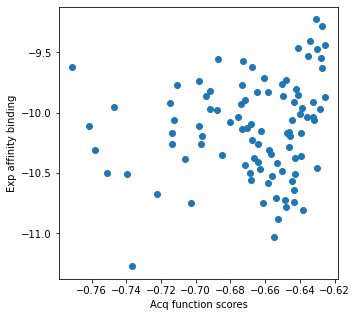

Run: 4
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -7.787
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.747383 - Seq: 9 - PEPTIDE1{F.V.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 449
N 002 - Score: -0.747383 - Seq: 9 - PEPTIDE1{F.V.F.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 409
N 003 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 416
N 004 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 413
N 005 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 393
N 006 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 392
N 007 - Score: -0.771522 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (004/050) - New s

N 083 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (036/050) - New seq: 323
N 084 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (037/050) - New seq: 323
N 085 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (038/050) - New seq: 345
N 086 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (039/050) - New seq: 328
N 087 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (040/050) - New seq: 332
N 088 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (041/050) - New seq: 334
N 089 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (042/050) - New seq: 329
N 090 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (043/050) - New seq: 357
N 091 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (044/050) - New seq: 312
N 092 - Score: -0.786771 - Seq: 9 - PEPTIDE1{Y.F.D.C.W.W.F.M.V}$$$$V2.0 (045/050) - New seq: 333
N 093 - Score: -0.786771 - Seq

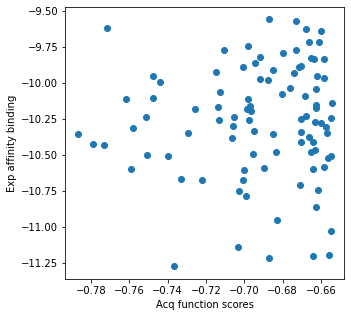

Run: 5
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -7.787
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.747381 - Seq: 9 - PEPTIDE1{F.V.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 442
N 002 - Score: -0.771520 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 411
N 003 - Score: -0.771520 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 416
N 004 - Score: -0.771520 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 383
N 005 - Score: -0.771520 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 388
N 006 - Score: -0.771520 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (004/050) - New seq: 350
N 007 - Score: -0.771520 - Seq: 9 - PEPTIDE1{F.V.A.C.D.W.F.A.M}$$$$V2.0 (005/050) - New s

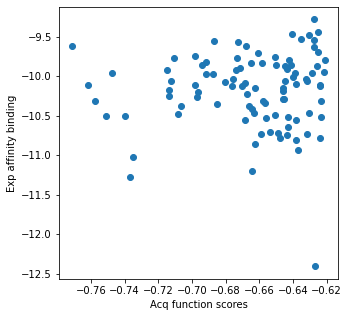

In [38]:
df = pd.read_csv('pca.csv')
f = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values

scaler = StandardScaler()
f = scaler.fit_transform(f)

df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = f

pcaseq = SequenceDescriptors(df)

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': TanimotoSimilarityKernel(), 'seq_transformer': map4, 'scaler': None,
              'n_gen': 1000, 'n_children': 500, 'temperature': 0.01, 'elitism': True, 'total_attempts': 50, 'cx_points': 2, 'pm': 0.1, 'minimum_mutations': 1, 'maximum_mutations': 5}

dmt = DMTSimulation(1, 5)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

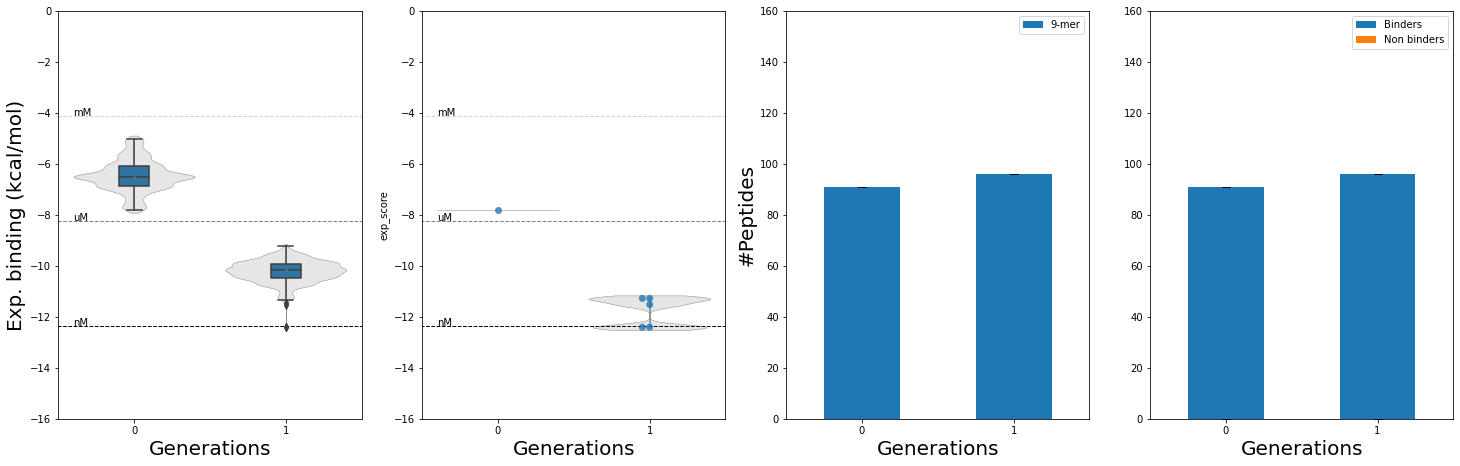

In [39]:
plot_results(df, 'test')

## Random mutation scanning

In [79]:
random_peptides = init_sequence.copy()
random_peptides_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in random_peptides]

AAS = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
n = np.floor(95 / 9).astype(int)

for seq in random_monomers_scanning(random_peptides_fasta[0], AAS, number_monomers_per_position=n):
    random_peptides_fasta.append(seq)
    
    if len(random_peptides_fasta) >= 96:
        print('Reach max. number of peptides allowed.')
        break

random_peptides = [build_helm_string({'PEPTIDE1': f}) for f in random_peptides_fasta]
random_peptide_scores = mps.score(random_peptides_fasta)

print(len(random_peptides_fasta))
print(random_peptides_fasta)
print(random_peptide_scores)

87
['HYECDWFAM', 'PYECDWFAM', 'LYECDWFAM', 'SYECDWFAM', 'FYECDWFAM', 'CYECDWFAM', 'RYECDWFAM', 'TYECDWFAM', 'EYECDWFAM', 'QYECDWFAM', 'HKECDWFAM', 'HAECDWFAM', 'HHECDWFAM', 'HDECDWFAM', 'HIECDWFAM', 'HFECDWFAM', 'HSECDWFAM', 'HTECDWFAM', 'HQECDWFAM', 'HNECDWFAM', 'HYPCDWFAM', 'HYHCDWFAM', 'HYNCDWFAM', 'HYLCDWFAM', 'HYTCDWFAM', 'HYCCDWFAM', 'HYKCDWFAM', 'HYICDWFAM', 'HYMCDWFAM', 'HYEWDWFAM', 'HYEHDWFAM', 'HYEDDWFAM', 'HYESDWFAM', 'HYEIDWFAM', 'HYEPDWFAM', 'HYENDWFAM', 'HYEKDWFAM', 'HYEMDWFAM', 'HYECSWFAM', 'HYECFWFAM', 'HYECIWFAM', 'HYECWWFAM', 'HYECPWFAM', 'HYECNWFAM', 'HYECYWFAM', 'HYECHWFAM', 'HYECVWFAM', 'HYECDIFAM', 'HYECDVFAM', 'HYECDDFAM', 'HYECDRFAM', 'HYECDNFAM', 'HYECDMFAM', 'HYECDAFAM', 'HYECDLFAM', 'HYECDFFAM', 'HYECDPFAM', 'HYECDWMAM', 'HYECDWPAM', 'HYECDWIAM', 'HYECDWGAM', 'HYECDWQAM', 'HYECDWDAM', 'HYECDWAAM', 'HYECDWTAM', 'HYECDWHAM', 'HYECDWNAM', 'HYECDWFLM', 'HYECDWFQM', 'HYECDWFWM', 'HYECDWFNM', 'HYECDWFGM', 'HYECDWFHM', 'HYECDWFPM', 'HYECDWFSM', 'HYECDWFRM', 'HYECDWF

Run: 1
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.636
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.776080 - Seq: 9 - PEPTIDE1{H.M.M.C.L.W.F.A.M}$$$$V2.0 (000/050) - New seq: 437
N 002 - Score: -0.930622 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 437
N 003 - Score: -0.930622 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 424
N 004 - Score: -0.930622 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 421
N 005 - Score: -0.930622 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 404
N 006 - Score: -0.970938 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (000/050) - New seq: 405
N 007 - Score: -0.970938 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (001/050) - New s

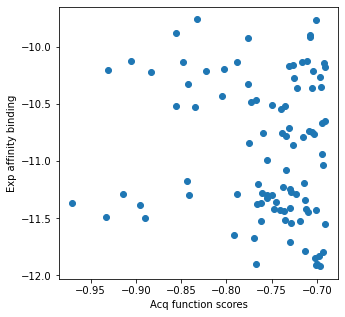

Run: 2
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.636
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.660941 - Seq: 9 - PEPTIDE1{H.M.I.C.L.W.F.A.M}$$$$V2.0 (000/050) - New seq: 430
N 002 - Score: -0.855542 - Seq: 9 - PEPTIDE1{H.M.L.C.L.W.F.A.M}$$$$V2.0 (000/050) - New seq: 431
N 003 - Score: -0.855542 - Seq: 9 - PEPTIDE1{H.M.L.C.L.W.F.A.M}$$$$V2.0 (001/050) - New seq: 425
N 004 - Score: -0.855542 - Seq: 9 - PEPTIDE1{H.M.L.C.L.W.F.A.M}$$$$V2.0 (002/050) - New seq: 411
N 005 - Score: -0.855542 - Seq: 9 - PEPTIDE1{H.M.L.C.L.W.F.A.M}$$$$V2.0 (003/050) - New seq: 386
N 006 - Score: -0.855542 - Seq: 9 - PEPTIDE1{H.M.L.C.L.W.F.A.M}$$$$V2.0 (004/050) - New seq: 382
N 007 - Score: -0.855542 - Seq: 9 - PEPTIDE1{H.M.L.C.L.W.F.A.M}$$$$V2.0 (005/050) - New s

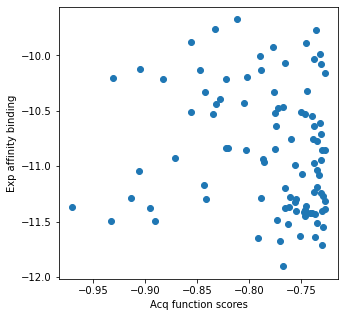

Run: 3
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.636
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.726680 - Seq: 9 - PEPTIDE1{H.L.M.A.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 437
N 002 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (000/050) - New seq: 443
N 003 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (001/050) - New seq: 414
N 004 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (002/050) - New seq: 412
N 005 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (003/050) - New seq: 374
N 006 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (004/050) - New seq: 378
N 007 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (005/050) - New s

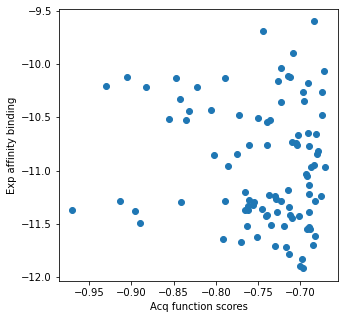

Run: 4
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.636
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.833037 - Seq: 9 - PEPTIDE1{H.M.L.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 424
N 002 - Score: -0.930622 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 452
N 003 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (000/050) - New seq: 443
N 004 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (001/050) - New seq: 392
N 005 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (002/050) - New seq: 392
N 006 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (003/050) - New seq: 372
N 007 - Score: -0.970939 - Seq: 9 - PEPTIDE1{H.L.M.C.D.W.F.A.V}$$$$V2.0 (004/050) - New s

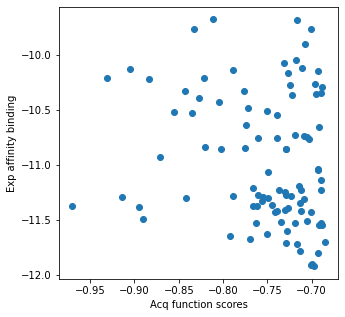

Run: 5
Exp dataset size: (91, 4096)


Init.
N pep:  91
Best peptide: -8.636
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.556019 - Seq: 9 - PEPTIDE1{H.M.F.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 432
N 002 - Score: -0.827735 - Seq: 9 - PEPTIDE1{H.M.L.C.D.W.F.A.L}$$$$V2.0 (000/050) - New seq: 427
N 003 - Score: -0.855542 - Seq: 9 - PEPTIDE1{H.M.L.C.L.W.F.A.M}$$$$V2.0 (000/050) - New seq: 448
N 004 - Score: -0.871710 - Seq: 9 - PEPTIDE1{H.M.L.C.D.W.F.A.V}$$$$V2.0 (000/050) - New seq: 420
N 005 - Score: -0.933450 - Seq: 9 - PEPTIDE1{H.M.M.C.L.W.F.A.V}$$$$V2.0 (000/050) - New seq: 410
N 006 - Score: -0.933450 - Seq: 9 - PEPTIDE1{H.M.M.C.L.W.F.A.V}$$$$V2.0 (001/050) - New seq: 409
N 007 - Score: -0.933450 - Seq: 9 - PEPTIDE1{H.M.M.C.L.W.F.A.V}$$$$V2.0 (002/050) - New s

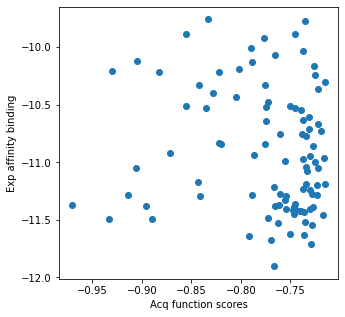

In [41]:
df = pd.read_csv('pca.csv')
f = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values

scaler = StandardScaler()
f = scaler.fit_transform(f)

df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = f

pcaseq = SequenceDescriptors(df)

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': TanimotoSimilarityKernel(), 'seq_transformer': map4, 'scaler': None,
              'n_gen': 1000, 'n_children': 500, 'temperature': 0.01, 'elitism': True, 'total_attempts': 50, 'cx_points': 2, 'pm': 0.1, 'minimum_mutations': 1, 'maximum_mutations': 5}

dmt = DMTSimulation(1, 5)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

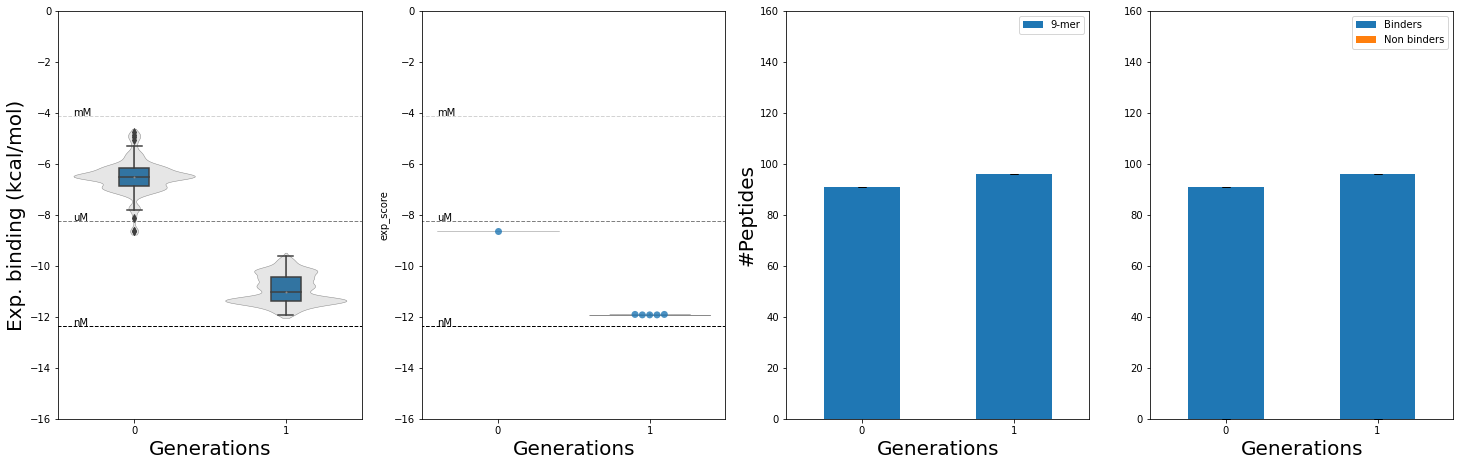

In [42]:
plot_results(df, 'test')

## Random mutation scanning... but by properties

In [84]:
random_peptides = init_sequence.copy()
random_peptides_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in random_peptides]

properties = {'polar_pos': ['R', 'H', 'K'],
              'polar_neg': ['E', 'D'],
              'polar_neutral': ['Q', 'T', 'G', 'C', 'N', 'S'],
              'polar_aro': ['Y', 'W', 'F'],
              'polar_nonaro': ['I', 'A', 'L', 'P', 'V', 'M']}

for seq in properties_scanning(random_peptides_fasta[0], properties):
    random_peptides_fasta.append(seq)
    
    if len(random_peptides_fasta) >= 96:
        print('Reach max. number of peptides allowed.')
        break

random_peptides_fasta = np.unique(random_peptides_fasta)
random_peptides = [build_helm_string({'PEPTIDE1': f}) for f in random_peptides_fasta]
random_peptide_scores = mps.score(random_peptides_fasta)

print(len(random_peptides_fasta))
print(random_peptides_fasta)
print(random_peptide_scores)

Reach max. number of peptides allowed.
84
['CYECDWFAM' 'DYECDWFAM' 'EYECDWFAM' 'FYECDWFAM' 'HCECDWFAM' 'HDECDWFAM'
 'HEECDWFAM' 'HGECDWFAM' 'HHECDWFAM' 'HIECDWFAM' 'HKECDWFAM' 'HLECDWFAM'
 'HNECDWFAM' 'HRECDWFAM' 'HVECDWFAM' 'HWECDWFAM' 'HYACDWFAM' 'HYDCDWFAM'
 'HYEADWFAM' 'HYECCWFAM' 'HYECDCFAM' 'HYECDEFAM' 'HYECDFFAM' 'HYECDKFAM'
 'HYECDMFAM' 'HYECDRFAM' 'HYECDTFAM' 'HYECDVFAM' 'HYECDWEAM' 'HYECDWFAA'
 'HYECDWFAD' 'HYECDWFAF' 'HYECDWFAG' 'HYECDWFAM' 'HYECDWFAN' 'HYECDWFAR'
 'HYECDWFAW' 'HYECDWFCM' 'HYECDWFDM' 'HYECDWFEM' 'HYECDWFFM' 'HYECDWFHM'
 'HYECDWFIM' 'HYECDWFKM' 'HYECDWFMM' 'HYECDWFNM' 'HYECDWIAM' 'HYECDWKAM'
 'HYECDWLAM' 'HYECDWNAM' 'HYECDWRAM' 'HYECDWSAM' 'HYECDWWAM' 'HYECDWYAM'
 'HYECEWFAM' 'HYECGWFAM' 'HYECHWFAM' 'HYECPWFAM' 'HYECRWFAM' 'HYECYWFAM'
 'HYEDDWFAM' 'HYEEDWFAM' 'HYEFDWFAM' 'HYEGDWFAM' 'HYEKDWFAM' 'HYELDWFAM'
 'HYENDWFAM' 'HYERDWFAM' 'HYFCDWFAM' 'HYGCDWFAM' 'HYHCDWFAM' 'HYKCDWFAM'
 'HYPCDWFAM' 'HYRCDWFAM' 'HYTCDWFAM' 'KYECDWFAM' 'MYECDWFAM' 'NYECDWFAM'
 'PYECDWF

Run: 1
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.106
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.383305 - Seq: 9 - PEPTIDE1{H.I.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 421
N 002 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 452
N 003 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 411
N 004 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 417
N 005 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 391
N 006 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (004/050) - New seq: 382
N 007 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (005/050) - New s

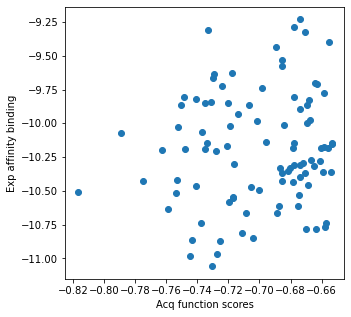

Run: 2
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.106
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.653560 - Seq: 9 - PEPTIDE1{F.I.A.C.F.W.F.A.M}$$$$V2.0 (000/050) - New seq: 440
N 002 - Score: -0.734766 - Seq: 9 - PEPTIDE1{F.I.A.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 458
N 003 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 428
N 004 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 435
N 005 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 401
N 006 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 377
N 007 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (004/050) - New s

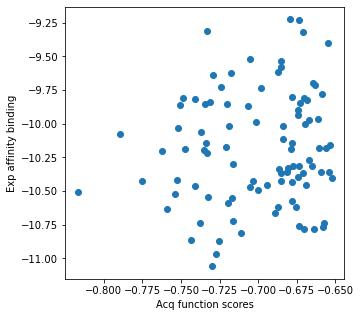

Run: 3
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.106
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.733061 - Seq: 9 - PEPTIDE1{F.Y.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 441
N 002 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 423
N 003 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 415
N 004 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 390
N 005 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 396
N 006 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (004/050) - New seq: 374
N 007 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (005/050) - New s

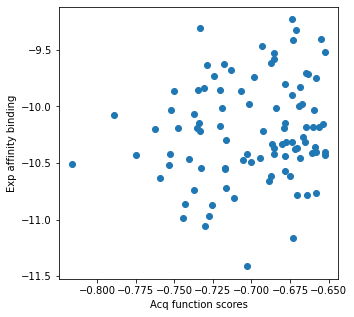

Run: 4
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.106
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.427212 - Seq: 9 - PEPTIDE1{F.Y.M.Y.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 433
N 002 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 436
N 003 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 426
N 004 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 405
N 005 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (003/050) - New seq: 401
N 006 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (004/050) - New seq: 388
N 007 - Score: -0.816655 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (005/050) - New s

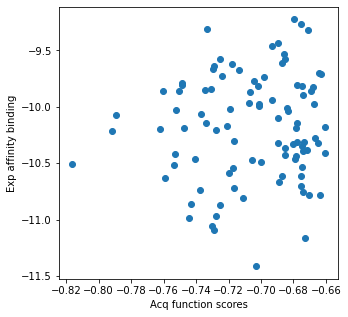

Run: 5
Exp dataset size: (96, 4096)


Init.
N pep:  96
Best peptide: -8.106
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
Non binding pep        : 000


Generation: 1
N 001 - Score: -0.733061 - Seq: 9 - PEPTIDE1{F.Y.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 431
N 002 - Score: -0.733061 - Seq: 9 - PEPTIDE1{F.Y.M.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 427
N 003 - Score: -0.743346 - Seq: 9 - PEPTIDE1{F.I.M.D.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 394
N 004 - Score: -0.816656 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (000/050) - New seq: 398
N 005 - Score: -0.816656 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (001/050) - New seq: 412
N 006 - Score: -0.816656 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (002/050) - New seq: 423
N 007 - Score: -0.816656 - Seq: 9 - PEPTIDE1{F.I.M.C.D.W.F.A.M}$$$$V2.0 (003/050) - New s

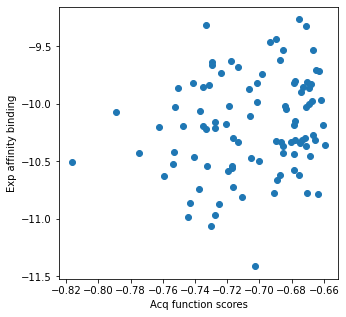

In [44]:
df = pd.read_csv('pca.csv')
f = df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values

scaler = StandardScaler()
f = scaler.fit_transform(f)

df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] = f

pcaseq = SequenceDescriptors(df)

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': TanimotoSimilarityKernel(), 'seq_transformer': map4, 'scaler': None,
              'n_gen': 1000, 'n_children': 500, 'temperature': 0.01, 'elitism': True, 'total_attempts': 50, 'cx_points': 2, 'pm': 0.1, 'minimum_mutations': 1, 'maximum_mutations': 5}

dmt = DMTSimulation(1, 5)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

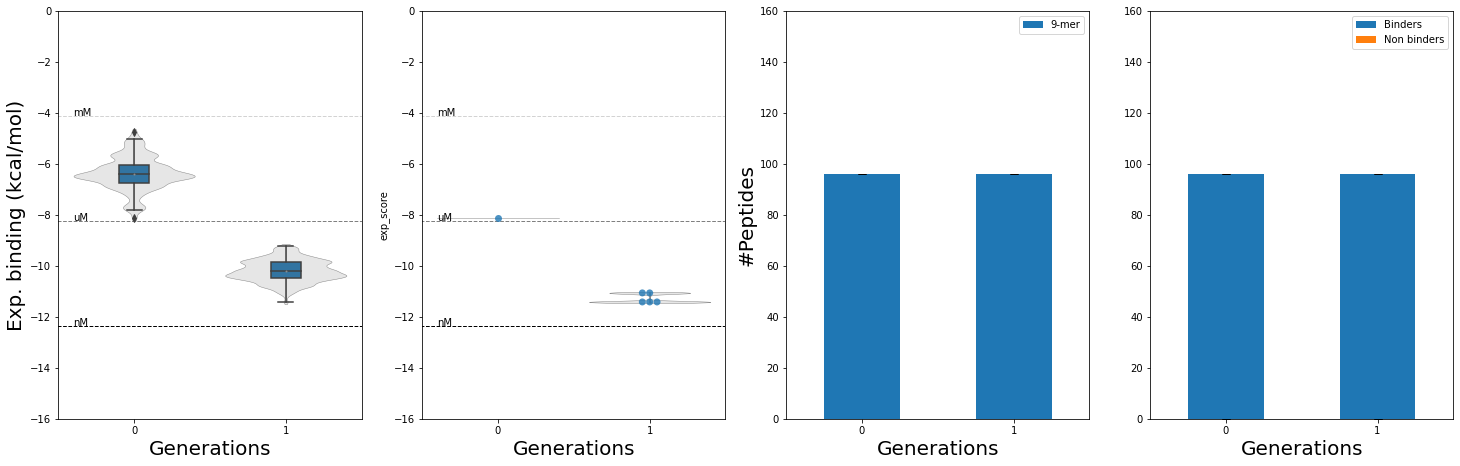

In [45]:
plot_results(df, 'test')

## Results analysis

In [33]:
data = []
columns = ['scanning_type', 'init_avg', 'init_min', 'gen_avg', 'gen_min']

scanning_types = ['alanine', 'properties', 'monomers', 'random_monomers', 'scrumbled']

for scanning_type in scanning_types:
    for i in range(100):
        try:
            df = pd.read_csv('results_scanning_%s_%d.csv' % (scanning_type, i + 1))
            mins = df.loc[df.groupby(by=['sample', 'gen'])['exp_score'].idxmin()][['gen', 'exp_score']].reset_index()['exp_score'].values
            avgs = df.groupby(by=['sample', 'gen'])['exp_score'].agg('mean').reset_index()['exp_score'].values
            
            for m, a in zip(mins[1:], avgs[1:]):
                data.append((scanning_type, avgs[0], mins[0], a, m))
        except:
            pass
        
df = pd.DataFrame(data=data, columns=columns)

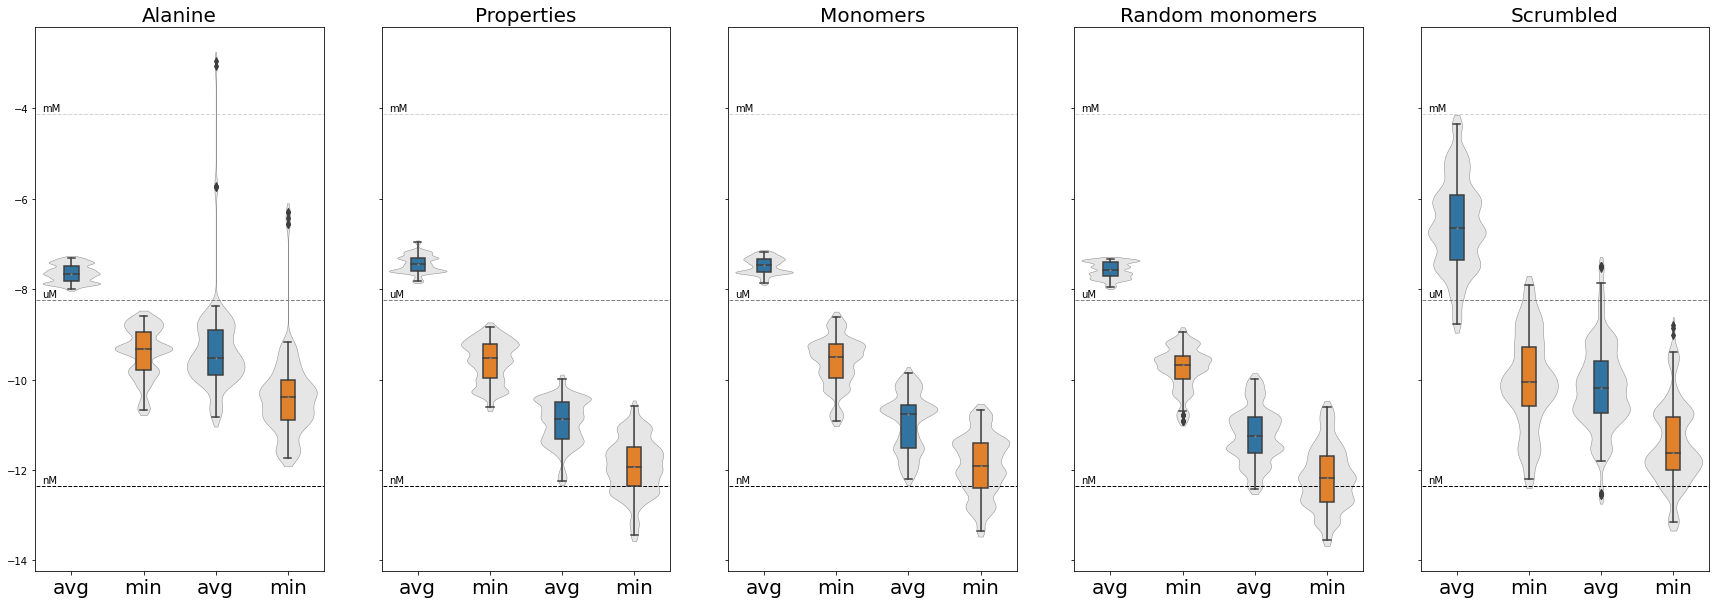

In [34]:
fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(30, 10))

for i, scanning_type in enumerate(scanning_types):
    x = [-1, 0, 1, 2, 3, 4, 5]
    axarr[i].plot(x, [affinity_binding_to_energy(1, unit='mM')] * len(x), '--', linewidth=1, color='lightgray')
    axarr[i].plot(x, [affinity_binding_to_energy(1, unit='uM')] * len(x), '--', linewidth=1, color='gray')
    axarr[i].plot(x, [affinity_binding_to_energy(1, unit='nM')] * len(x), '--', linewidth=1, color='black')
    axarr[i].text(-0.4, affinity_binding_to_energy(1.1, unit='mM'), 'mM')
    axarr[i].text(-0.4, affinity_binding_to_energy(1.1, unit='uM'), 'uM')
    axarr[i].text(-0.4, affinity_binding_to_energy(1.1, unit='nM'), 'nM')
    
    axarr[i].set_title(scanning_type.capitalize().replace('_', ' '), fontsize=20)
    sns.violinplot(data=df[df['scanning_type'] == scanning_type][['init_avg', 'init_min', 'gen_avg', 'gen_min']], bw=.2, scale='width', cut=1, linewidth=0.5, color="0.9", ax=axarr[i])
    sns.boxplot(data=df[df['scanning_type'] == scanning_type], width=.2, boxprops={'zorder': 2}, palette=['tab:blue', 'tab:orange'], ax=axarr[i])
    
    try:
        axarr[i].set_xticklabels(["avg", "min", "avg", "min"], fontsize=20)
    except:
        pass
    
plt.savefig('figure_scanning_protocol.png', bbox_inches='tight', dpi=300)
plt.show()